# 1. 강의영상 

{{<video https://youtu.be/playlist?list=PLQqh36zP38-xD3gCT0L9vDSnXHHEpxP0E&si=PUo87ILydVK7moIk >}}

# 2. Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
#---#
import pickle
from autogluon.tabular import TabularPredictor
import autogluon.eda.auto as auto
#---#
import warnings
warnings.filterwarnings('ignore')

# 3. Data

In [4]:
temp = pd.read_csv('https://raw.githubusercontent.com/guebin/DV2022/master/posts/temp.csv').iloc[:,3].to_numpy()[:100]
temp.sort()
np.random.seed(43052)
eps = np.random.randn(100)*3 # 오차
icecream_sales = 20 + temp * 2.5 + eps 
df_train = pd.DataFrame({'temp':temp,'sales':icecream_sales})

<AxesSubplot: xlabel='temp', ylabel='sales'>

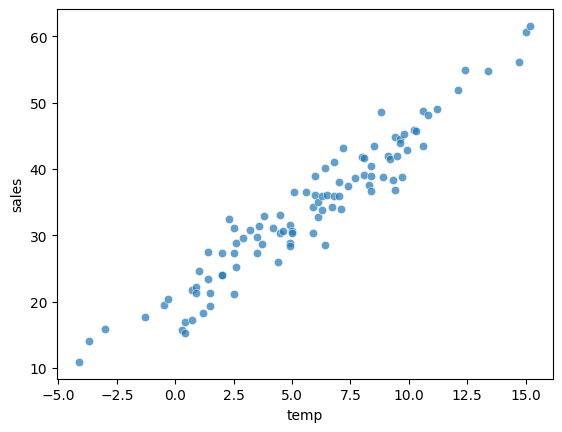

In [8]:
sns.scatterplot(df_train, x='temp',y='sales', alpha=0.7)

# 4. 적합

## A. 맨날 쓰는 코드

In [9]:
# step1 -- pass 
# step2
predictr = TabularPredictor(label='sales')
# step3 
predictr.fit(df_train, num_gpus=1)
# step4 
yhat = predictr.predict(df_train)

No path specified. Models will be saved in: "AutogluonModels/ag-20231211_060143/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231211_060143/"
AutoGluon Version:  0.8.1
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #34~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Sep  7 13:12:03 UTC 2
Disk Space Avail:   441.11 GB / 982.82 GB (44.9%)
Train Data Rows:    100
Train Data Columns: 1
Label Column: sales
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (61.561043278721556, 10.90026146402572, 33.97342, 10.63375)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the dat

[1000]	valid_set's rmse: 5.45375
[2000]	valid_set's rmse: 5.40245


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
	-5.3708	 = Validation score   (-root_mean_squared_error)
	0.16s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4.4041	 = Validation score   (-root_mean_squared_error)
	0.22s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: CatBoost ...
	Training CatBoost with GPU, note that this may negatively impact model quality compared to CPU training.
	-4.321	 = Validation score   (-root_mean_squared_error)
	1.6s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4.2375	 = Validation score   (-root_mean_squared_error)
	0.2s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-3.7128	 = Validation score   (-root_mean_squared_error)
	0.43s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: XGBoost ...
	-4.0555	 = Validation score   (-root_mean_squar

## B. 적합결과 시각화 

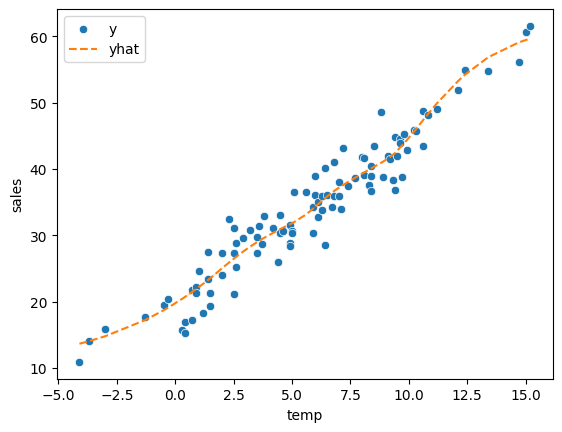

In [13]:
sns.scatterplot(df_train, x='temp',y='sales',label='y')
sns.lineplot(df_train, x='temp',y=yhat,color='C1',linestyle='--',label='yhat')
plt.legend()

- 잘 맞춘다? 

## C. 모형들 확인 

In [15]:
predictr.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch,-3.439942,0.002109,0.494289,0.002109,0.494289,1,True,10
1,WeightedEnsemble_L2,-3.439942,0.002322,0.663001,0.000213,0.168712,2,True,12
2,NeuralNetFastAI,-3.712792,0.004203,0.430591,0.004203,0.430591,1,True,8
3,LightGBMLarge,-3.978956,0.000680,0.202624,0.000680,0.202624,1,True,11
4,XGBoost,-4.055491,0.001820,0.523818,0.001820,0.523818,1,True,9
5,KNeighborsUnif,-4.211090,0.013607,0.010296,0.013607,0.010296,1,True,1
6,ExtraTreesMSE,-4.237516,0.023564,0.199401,0.023564,0.199401,1,True,7
7,CatBoost,-4.321046,0.000912,1.603749,0.000912,1.603749,1,True,6
8,RandomForestMSE,-4.404096,0.022882,0.218408,0.022882,0.218408,1,True,5
9,KNeighborsDist,-4.671405,0.012330,0.002862,0.012330,0.002862,1,True,2


- Pytorch를 이용한 NeuralNet이 가장 좋은 성능을 보임.

## D. 최강모형의 `r2_score` 계산

`-` `r2_score` 계산 -- 방법1

In [19]:
_y = df_train.sales
_yhat = predictr.predict(df_train)
sklearn.metrics.r2_score(_y,_yhat)

0.9297829364008559

`-` `r2_score` 계산 -- 방법2

In [22]:
# 지금 predictr에는 여러 개의 모델이 있다.
_y = df_train.sales
_yhat = predictr.predict(df_train,model='NeuralNetTorch')
sklearn.metrics.r2_score(_y,_yhat)

0.9297829364008559

## E. 특정모형의 적합값 구경 

`-` XGBoost 궁금해..

In [23]:
_y = df_train.sales
_yhat = predictr.predict(df_train,model='XGBoost')
sklearn.metrics.r2_score(_y,_yhat)

0.9516437954914487

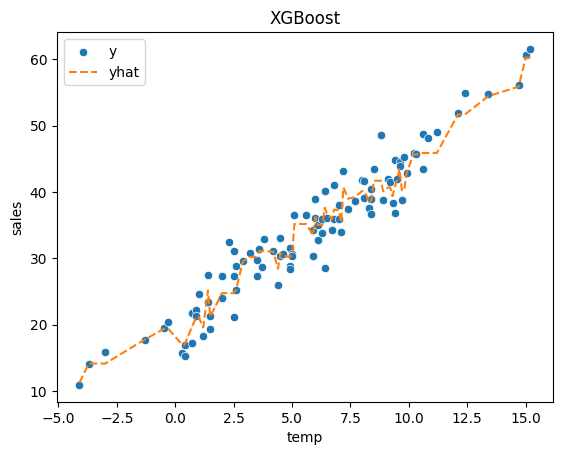

In [27]:
sns.scatterplot(df_train, x='temp', y='sales', label='y')
sns.lineplot(df_train, x='temp',y=_yhat,color='C1',linestyle='--',label='yhat')
ax = plt.gca()
ax.set_title("XGBoost")
plt.legend()